In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [7]:
# STEP 1 – Load Raw K-index Data
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

k_index_path = "C:/Users/Acer/Documents/Subjects/INFO580-MBusDataSc Research Project/Predicting Geomagnetic Storms/Data/EYR_2014_k.txt"

# Load file
k_df_raw = pd.read_csv(
    k_index_path,
    comment="#",
    sep=r"\s+",
    header=None,
    names=["STA", "YR", "MTH", "DAY", "1", "2", "3", "4", "5", "6", "7", "8"],
    dtype=str
)

# Step 1: Drop empty rows before filtering numeric
k_df_raw = k_df_raw.dropna(subset=["YR"])
k_df_raw = k_df_raw[k_df_raw["YR"].str.isnumeric()]

# Convert types
k_df_raw["YR"] = k_df_raw["YR"].astype(int)
k_df_raw["MTH"] = k_df_raw["MTH"].astype(int)
k_df_raw["DAY"] = k_df_raw["DAY"].astype(int)

# Replace -1 with NaN in K-values
k_columns = ["1", "2", "3", "4", "5", "6", "7", "8"]
k_df_raw[k_columns] = k_df_raw[k_columns].replace("-1", np.nan).astype(float)

# STEP 2 – Show Table WITH January (Before Drop)
print("K-index table BEFORE dropping January (shows missing values as NaN):")
display(k_df_raw[["YR", "MTH", "DAY"] + k_columns].head(50))

# Count missing values BEFORE dropping Jan
missing_before = k_df_raw[k_columns].isna().sum().sum()
print(f"Total missing values before dropping January: {missing_before}")

# STEP 3 – Drop January (Keep Feb–Dec)
k_df = k_df_raw[k_df_raw["MTH"] != 1].copy()

# STEP 4 – KNN Imputation
imputer = KNNImputer(n_neighbors=5)
k_df[k_columns] = imputer.fit_transform(k_df[k_columns])

# Add date for index
k_df["date"] = pd.to_datetime(dict(year=k_df["YR"], month=k_df["MTH"], day=k_df["DAY"]))
k_df.set_index("date", inplace=True)

# Restore `k_long` from KNN-imputed k_df
k_columns = ["1", "2", "3", "4", "5", "6", "7", "8"]

k_long = k_df.reset_index().melt(
    id_vars=["YR", "MTH", "DAY", "date"],
    value_vars=k_columns,
    var_name="interval",
    value_name="k_value"
)

k_long["interval"] = k_long["interval"].astype(int)
k_long["hour_offset"] = (k_long["interval"] - 1) * 3
k_long["datetime"] = pd.to_datetime(k_long["date"]) + pd.to_timedelta(k_long["hour_offset"], unit="h")
k_long = k_long.sort_values("datetime").reset_index(drop=True)

# STEP 5 – Show Imputed Table 
print("K-index table AFTER KNN imputation (Feb–Dec):")
display(k_df[k_columns].head(50))

# Check for missing values after KNN
missing_after = k_df[k_columns].isna().sum().sum()
print(f"Total missing values AFTER KNN: {missing_after}")

# STEP 5 – Convert to Long Format with Accurate Datetime

# Ensure interval is integer and compute 3-hour offset
k_columns = ["1", "2", "3", "4", "5", "6", "7", "8"]
k_long = k_df.reset_index().melt(
    id_vars=["YR", "MTH", "DAY", "date"],
    value_vars=k_columns,
    var_name="interval",
    value_name="k_value"
)

# Ensure correct type
k_long["interval"] = k_long["interval"].astype(int)

# Calculate the offset in hours (0h, 3h, ..., 21h)
k_long["hour_offset"] = (k_long["interval"] - 1) * 3

# Create the true datetime for each 3-hour block
k_long["datetime"] = pd.to_datetime(k_long["date"]) + pd.to_timedelta(k_long["hour_offset"], unit="h")

# Sort and reset index
k_long = k_long.sort_values("datetime").reset_index(drop=True)

# STEP 6 – Show Output + Validate
print("Final 3-hourly K-index long-format table:")
display(k_long.head(16))

print("Datetime Range:", k_long["datetime"].min(), "→", k_long["datetime"].max())
print("Total 3-hour records:", len(k_long))
print("Any Missing K-index Values:", k_long["k_value"].isna().sum())



K-index table BEFORE dropping January (shows missing values as NaN):


,YR,MTH,DAY,1,2,3,4,5,6,7,8
1,2014,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2014,1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total missing values before dropping January: 160
K-index table AFTER KNN imputation (Feb–Dec):


,1,2,3,4,5,6,7,8
date,,,,,,,,
2014-02-01,0.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0
2014-02-02,1.0,2.0,2.0,0.0,0.0,1.0,2.0,1.0
2014-02-03,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.4
2014-02-04,1.2,2.0,1.0,0.0,0.0,0.0,1.0,1.0
2014-02-05,1.0,2.0,2.0,0.0,2.0,0.0,1.0,2.0
2014-02-06,2.0,3.0,1.0,2.0,3.0,2.0,2.0,1.0
2014-02-07,0.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0
2014-02-08,5.0,4.0,4.0,2.0,3.0,2.0,2.0,2.0
2014-02-09,3.0,2.0,3.0,0.0,3.0,2.0,3.0,2.0


Total missing values AFTER KNN: 0
Final 3-hourly K-index long-format table:


,YR,MTH,DAY,date,interval,k_value,hour_offset,datetime
0,2014,2,1,2014-02-01,1,0.0,0,2014-02-01 00:00:00
1,2014,2,1,2014-02-01,2,1.0,3,2014-02-01 03:00:00
2,2014,2,1,2014-02-01,3,1.0,6,2014-02-01 06:00:00
3,2014,2,1,2014-02-01,4,0.0,9,2014-02-01 09:00:00
4,2014,2,1,2014-02-01,5,1.0,12,2014-02-01 12:00:00
5,2014,2,1,2014-02-01,6,1.0,15,2014-02-01 15:00:00
6,2014,2,1,2014-02-01,7,2.0,18,2014-02-01 18:00:00
7,2014,2,1,2014-02-01,8,2.0,21,2014-02-01 21:00:00
8,2014,2,2,2014-02-02,1,1.0,0,2014-02-02 00:00:00
9,2014,2,2,2014-02-02,2,2.0,3,2014-02-02 03:00:00


Datetime Range: 2014-02-01 00:00:00 → 2014-12-31 21:00:00
Total 3-hour records: 2672
Any Missing K-index Values: 0


In [6]:

# STEP 2 – Load and Fix Minute-Level Magnetic Data
mag_path = "C:/Users/Acer/Documents/Subjects/INFO580-MBusDataSc Research Project/Predicting Geomagnetic Storms/Data/eyrxyz2014_fil_reduced.csv"

# Load file (Date only, no time info)
mag_df = pd.read_csv(mag_path)
mag_df.columns = ["date", "eyrx", "eyry"]

# Convert 'date' to datetime (assumes 1 row per minute)
mag_df["date"] = pd.to_datetime(mag_df["date"], format="%d/%m/%Y")

# Add synthetic time: 1 row per minute
mag_df["datetime"] = pd.date_range(start=mag_df["date"].min(), periods=len(mag_df), freq="T")
mag_df = mag_df.drop(columns="date")  # drop old 'date' column

# Drop January
mag_df = mag_df[mag_df["datetime"].dt.month != 1]

# Set datetime index and resample to 3-hour blocks
mag_df.set_index("datetime", inplace=True)
mag_df_3h = mag_df.resample("3H").mean().dropna().reset_index()

# Optional: round values
mag_df_3h["eyrx"] = mag_df_3h["eyrx"].round(2)
mag_df_3h["eyry"] = mag_df_3h["eyry"].round(2)

# Preview result
print("Magnetic field converted to true 3-hour format:")
display(mag_df_3h.head(16))

Magnetic field converted to true 3-hour format:


C:\Users\Acer\AppData\Local\Temp\ipykernel_19160\1950684771.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mag_df["datetime"] = pd.date_range(start=mag_df["date"].min(), periods=len(mag_df), freq="T")
C:\Users\Acer\AppData\Local\Temp\ipykernel_19160\1950684771.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mag_df_3h = mag_df.resample("3H").mean().dropna().reset_index()


,datetime,eyrx,eyry
0,2014-02-01 00:00:00,19277.88,8431.38
1,2014-02-01 03:00:00,19315.74,8425.36
2,2014-02-01 06:00:00,19319.93,8402.66
3,2014-02-01 09:00:00,19313.12,8395.30
4,2014-02-01 12:00:00,19311.66,8389.28
5,2014-02-01 15:00:00,19312.21,8385.62
6,2014-02-01 18:00:00,19295.05,8350.10
7,2014-02-01 21:00:00,19265.78,8372.61
8,2014-02-02 00:00:00,19278.15,8444.41
9,2014-02-02 03:00:00,19308.25,8425.10


In [4]:
# Merge on 3-hour datetime
merged_df = pd.merge(k_long, mag_df_3h, on="datetime", how="inner")

# Drop any rows with remaining NaNs
merged_df = merged_df.dropna().reset_index(drop=True)

# Optional: Preview
display(merged_df.head(20))


,YR,MTH,DAY,date,interval,k_value,hour_offset,datetime,eyrx,eyry
0,2014,2,1,2014-02-01,1,0.0,0,2014-02-01 00:00:00,19277.88,8431.38
1,2014,2,1,2014-02-01,2,1.0,3,2014-02-01 03:00:00,19315.74,8425.36
2,2014,2,1,2014-02-01,3,1.0,6,2014-02-01 06:00:00,19319.93,8402.66
3,2014,2,1,2014-02-01,4,0.0,9,2014-02-01 09:00:00,19313.12,8395.30
4,2014,2,1,2014-02-01,5,1.0,12,2014-02-01 12:00:00,19311.66,8389.28
5,2014,2,1,2014-02-01,6,1.0,15,2014-02-01 15:00:00,19312.21,8385.62
6,2014,2,1,2014-02-01,7,2.0,18,2014-02-01 18:00:00,19295.05,8350.10
7,2014,2,1,2014-02-01,8,2.0,21,2014-02-01 21:00:00,19265.78,8372.61
8,2014,2,2,2014-02-02,1,1.0,0,2014-02-02 00:00:00,19278.15,8444.41
9,2014,2,2,2014-02-02,2,2.0,3,2014-02-02 03:00:00,19308.25,8425.10


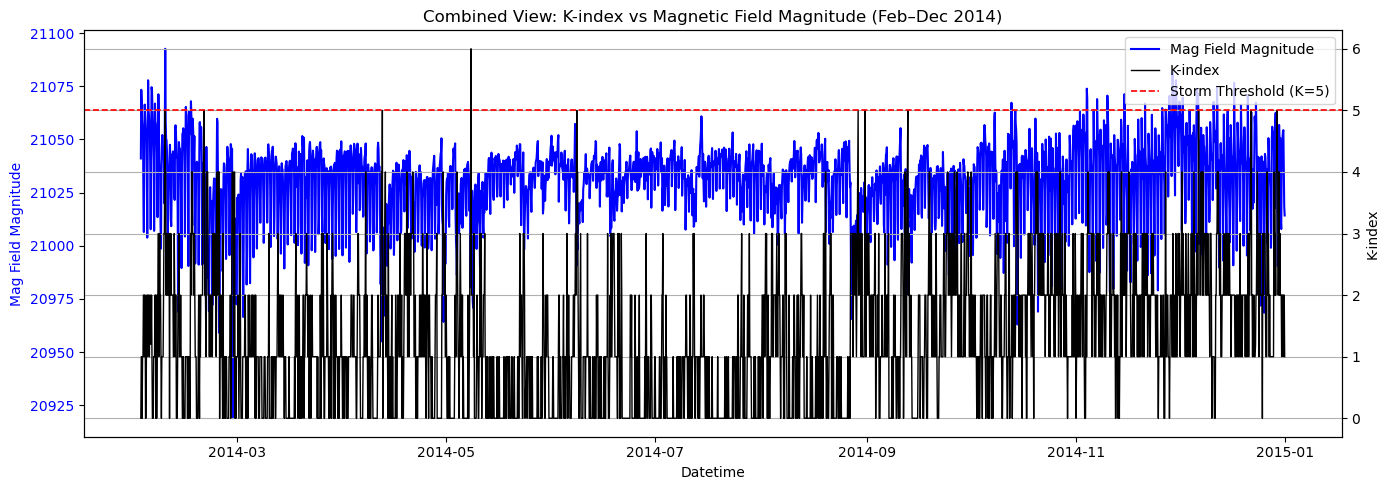

,YR,MTH,DAY,date,interval,k_value,hour_offset,datetime,eyrx,eyry,mag_magnitude,mag,mag_smooth,dEyRx_dt,dEyRy_dt,dHdt_magnitude
0,2014,2,1,2014-02-01,1,0.0,0,2014-02-01 00:00:00,19277.88,8431.38,21041.027209,21041.027209,NaN,NaN,NaN,NaN
1,2014,2,1,2014-02-01,2,1.0,3,2014-02-01 03:00:00,19315.74,8425.36,21073.312575,21073.312575,21060.809722,0.210333,-0.033444,0.212976
2,2014,2,1,2014-02-01,3,1.0,6,2014-02-01 06:00:00,19319.93,8402.66,21068.089384,21068.089384,21066.770462,0.023278,-0.126111,0.128241
3,2014,2,1,2014-02-01,4,0.0,9,2014-02-01 09:00:00,19313.12,8395.30,21058.909426,21058.909426,21060.723310,-0.037833,-0.040889,0.055707
4,2014,2,1,2014-02-01,5,1.0,12,2014-02-01 12:00:00,19311.66,8389.28,21055.171120,21055.171120,21056.099375,-0.008111,-0.033444,0.034414
5,2014,2,1,2014-02-01,6,1.0,15,2014-02-01 15:00:00,19312.21,8385.62,21054.217579,21054.217579,21044.578231,0.003056,-0.020333,0.020562
6,2014,2,1,2014-02-01,7,2.0,18,2014-02-01 18:00:00,19295.05,8350.10,21024.345995,21024.345995,21028.337347,-0.095333,-0.197333,0.219155
7,2014,2,1,2014-02-01,8,2.0,21,2014-02-01 21:00:00,19265.78,8372.61,21006.448468,21006.448468,21025.764547,-0.162611,0.125056,0.205137
8,2014,2,2,2014-02-02,1,1.0,0,2014-02-02 00:00:00,19278.15,8444.41,21046.499178,21046.499178,21039.763712,0.068722,0.398889,0.404765
9,2014,2,2,2014-02-02,2,2.0,3,2014-02-02 03:00:00,19308.25,8425.10,21066.343491,21066.343491,21058.290440,0.167222,-0.107278,0.198675


In [7]:
# Step 1: Merge on Common 3-hour Timestamps
merged_df = pd.merge(k_long, mag_df_3h, on="datetime", how="inner")

# Ensure 'datetime' is a column and in datetime64 format
if 'datetime' not in merged_df.columns:
    merged_df.reset_index(inplace=True)
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

# Calculate magnitude if needed
merged_df["mag_magnitude"] = (merged_df["eyrx"]**2 + merged_df["eyry"]**2)**0.5

# Add magnitude + smoothed fields to merged_df (AFTER merge!)
merged_df["mag"] = np.sqrt(merged_df["eyrx"]**2 + merged_df["eyry"]**2)
merged_df["mag_smooth"] = merged_df["mag_magnitude"].rolling(window=3, center=True).mean()

merged_df["dEyRx_dt"] = merged_df["eyrx"].diff() / 180  # assuming 3h steps = 180 minutes
merged_df["dEyRy_dt"] = merged_df["eyry"].diff() / 180
merged_df["dHdt_magnitude"] = np.sqrt(merged_df["dEyRx_dt"]**2 + merged_df["dEyRy_dt"]**2)

# STEP 2: Plot Combined View (K-index vs Magnetic Magnitude)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot magnetic magnitude
ax1.plot(merged_df["datetime"], merged_df["mag_magnitude"], color='blue', label="Mag Field Magnitude")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Mag Field Magnitude", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second axis for K-index
ax2 = ax1.twinx()
ax2.plot(merged_df["datetime"], merged_df["k_value"], color='black', label="K-index", linewidth=1)
ax2.set_ylabel("K-index", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Optional: Storm threshold (K ≥ 5)
ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.2, label="Storm Threshold (K=5)")

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.title("Combined View: K-index vs Magnetic Field Magnitude (Feb–Dec 2014)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Preview
display(merged_df.head(20))


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


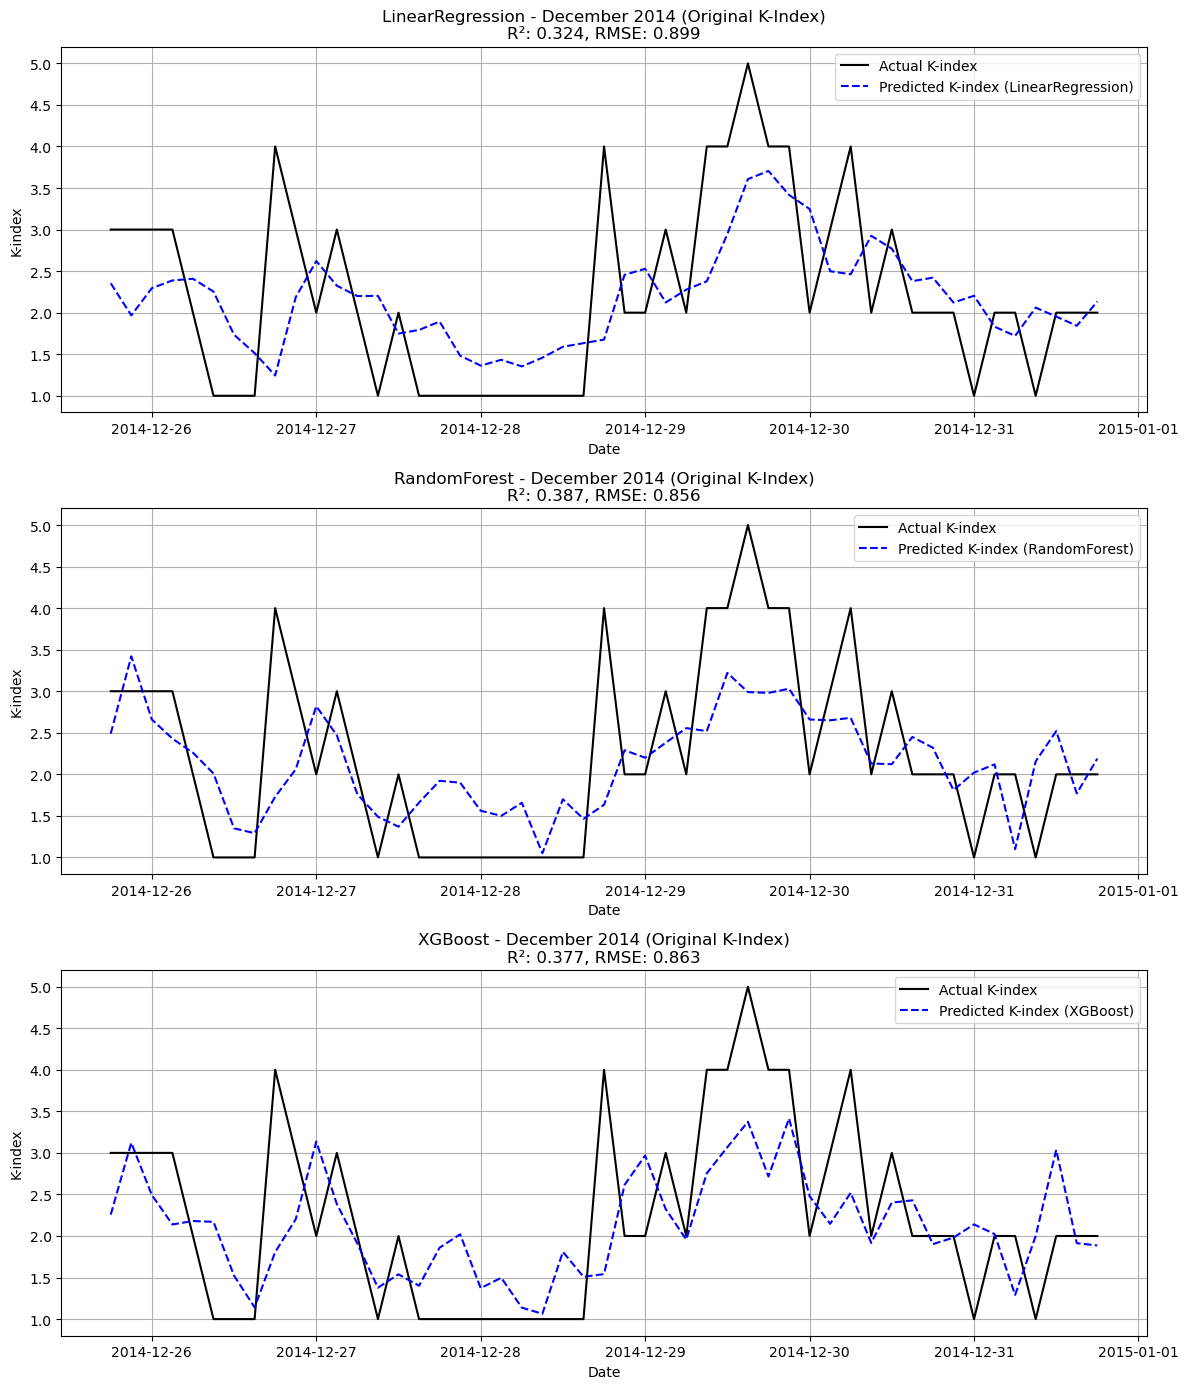

In [12]:
# Step 1: Setup
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 2: Filter December Data
dec_df = merged_df[(merged_df["datetime"] >= '2014-12-01') & (merged_df["datetime"] < '2015-01-01')].copy()

# Step 3: Create Lag Features and Magnetic Diffs 
dec_df["k_lag1"] = dec_df["k_value"].shift(1)
dec_df["k_lag2"] = dec_df["k_value"].shift(2)
dec_df["k_lag3"] = dec_df["k_value"].shift(3)

dec_df["eyrx_diff"] = dec_df["eyrx"].diff()
dec_df["eyry_diff"] = dec_df["eyry"].diff()

# Drop rows with missing values from lags/diffs
dec_df.dropna(inplace=True)

# Step 4: Define Features and Target
features = ['k_lag1', 'k_lag2', 'k_lag3', 'eyrx', 'eyry', 'eyrx_diff', 'eyry_diff']
X = dec_df[features]
y = dec_df["k_value"].values
dates = dec_df["datetime"].values

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

# Step 6: Initialize Models 
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Step 7: Train, Predict, Score 
plt.figure(figsize=(12, 14))

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Plotting
    plt.subplot(3, 1, i)
    plt.plot(dates_test, y_test, color='black', label='Actual K-index')
    plt.plot(dates_test, y_pred, linestyle='--', color='blue', label=f'Predicted K-index ({name})')
    plt.title(f"{name} - December 2014 (Original K-Index)\nR²: {r2:.3f}, RMSE: {rmse:.3f}")
    plt.xlabel("Date")
    plt.ylabel("K-index")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
